In [1]:
from tqdm import tqdm
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
import itertools
import ipywidgets as widgets
from IPython.display import display

In [7]:
np.random.seed(1)

# Distribution parameters
mean_a, std_a = 0.5, 1
mean_b, std_b = 0.0, 1

# Domain of alpha values to test
# Testing num values of (alpha_min - alpha_max) / num
alpha_min, alpha_max = 0.1, 1
alphas = np.linspace(alpha_min, alpha_max, num=100)

# Sample size of each distribution
sample_size = 150

# Generate samples from normal distributions
np.random.seed(1)
a = np.random.normal(mean_a, std_a, sample_size)
b = np.random.normal(mean_b, std_b, sample_size)

#Step Parameters
# U+ / U- > C+ / C-
u_plus = 1
u_minus = -1.1
c_plus = 1
c_minus = -c_plus
range = (-3, 3)
interval = 0.1

In [8]:
from utils import opt_threshold, alt_fair_opt_step

# Store results
x = []
fair_mean_A = []
fair_mean_B = []
fair_threshold_A = []
fair_threshold_B = []
total_util = []


y6 = opt_threshold((-3, 3), u_plus=1, u_minus=-1)

# Run fair optimization over a range of alpha values
for alpha in tqdm(alphas):
    results = alt_fair_opt_step(a, b, u_plus, u_minus, c_plus, c_minus, alpha, range, interval)
    if results[0] is not None and results[1] is not None:
        A, B, thresh_A, thresh_B, max_util = results
        x.append(alpha)
        
        fair_mean_A.append(np.mean(A))
        fair_mean_B.append(np.mean(B))
        fair_threshold_A.append(thresh_A)
        fair_threshold_B.append(thresh_B)
        total_util.append(max_util)  # Scale utility for better visualization

100%|██████████| 100/100 [00:01<00:00, 54.31it/s]


In [9]:
def plot_fairness(show_means=True, show_fair_thresholds=True, show_opt_thresholds=True, show_utility=True):
    plt.figure(figsize=(10, 6))

    if show_means:
        plt.plot(0, mean_a, 'ro', label='Initial μ(A)')
        plt.plot(0, mean_b, 'bo', label='Initial μ(B)')
        plt.plot(x, fair_mean_A, label="Fair μ(A)'", color='red')
        plt.plot(x, fair_mean_B, label="Fair μ(B)'", color='blue') 

    if show_fair_thresholds:
        plt.scatter(x, fair_threshold_A, label="Fair Threshold (A)", color='orange')
        plt.scatter(x, fair_threshold_B, label="Fair Threshold (B)", color='purple')
    
    if show_opt_thresholds:
        plt.axhline(y6, color='purple', linestyle='--', label='Optimal Threshold')

    if show_utility:
        plt.plot(x, total_util, label='Total Utility', color='green')

    plt.title("Fair vs. Optimal Means under Varying Fairness Constraint α")
    plt.xlabel("α (Fairness Threshold)")
    plt.ylabel("Metric Value")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Toggle widgets
means_toggle = widgets.Checkbox(value=True, description='Show Means')
fair_thresholds_toggle = widgets.Checkbox(value=True, description='Show Fair Thresholds')
opt_thresholds_toggle = widgets.Checkbox(value=True, description='Show Optimal Threshold')
utility_toggle = widgets.Checkbox(value=True, description='Show Utility')

ui = widgets.HBox([means_toggle, fair_thresholds_toggle, opt_thresholds_toggle, utility_toggle])
out = widgets.interactive_output(plot_fairness, {
    'show_means': means_toggle,
    'show_fair_thresholds': fair_thresholds_toggle,
    'show_opt_thresholds': opt_thresholds_toggle,
    'show_utility': utility_toggle,
})

display(ui, out)

Output()

In [8]:
print(y6)
results = alt_fair_opt_step(pop_A=a, pop_B=b, u_plus=1, u_minus=-1, c_plus=1, c_minus=-1, alpha=0.5, range_param=(-3, 3), size=0.01)
from utils import alt_fair_step
l = alt_fair_step(a, b, 1, -1, 1, -1, 0.5, (-3, 3), 0.01)

print(np.sum(results[0] + results[1]))
print(np.sum(l[0] + l[1]))


-4.440892098500626e-16
73.69532793297168
73.69532793297168


-6.394884621840902e-14


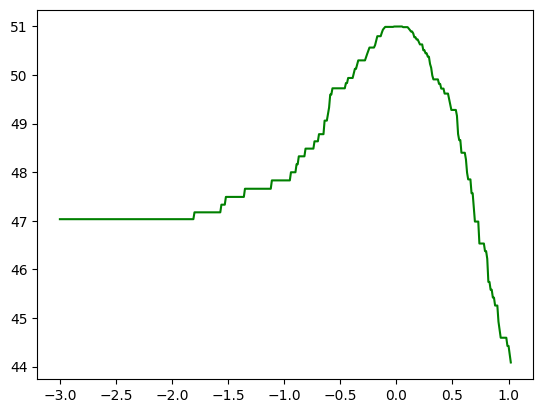

In [10]:
from utils import opt_step, alt_fair_opt_step, expected

# Store results
thresholds = np.arange(-3, 3, 0.01)
x = []


max_util = -np.inf
for i in thresholds:
    B = np.where(b > i, b + expected(b, c_plus, c_minus), b)
    util = np.sum(expected(B, u_plus, u_minus))
    if  util > max_util:
        max_util = util
        fair = i
print(fair)
total_util = []

delta_A = expected(a, c_plus, c_minus)
delta_B = expected(b, c_plus, c_minus)
B = np.where(b > fair, b + delta_B, b)
util_B = np.sum(expected(B, u_plus, u_minus))

for threshold in thresholds:
    alpha = 0.5
    A = np.where(a > threshold, a + delta_A, a)
    if np.abs(np.mean(A) - np.mean(B)) < alpha:
        continue
    utility = np.sum(expected(A, u_plus, u_minus)) + util_B
    total_util.append(utility)
    x.append(threshold)

plt.plot(x, total_util, label='Total Utility', color='green')
